In [6]:
import numpy as np

def gauss1dfunct(p, xgrid):
    """
    For this function, we need to input the four parameters in p [p[0], p[1], p[2], and p[3]], 
    and the x range in data. The parameters refer to the constant term, amplitude term, 
    stdev term, and center term respectively.
    The output will be y and the jacobian.
    """
    
    U0 = (xgrid - p[3]) / p[2]
    U = U0**2
    U2 = p[1] * U0 / p[2]
    U3 = U2 * U0
    expU = np.exp(-U / 2)
    
    y = p[0] + p[1] * expU
    
    # The Jacobian of Gauss1d
    jac = np.zeros((len(xgrid), 4))
    jac[:, 0] = 1.0
    jac[:, 1] = expU
    jac[:, 2] = U3 * expU
    jac[:, 3] = U2 * expU
    
    return y, jac

In [10]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

def smooth(y, span):
    return savgol_filter(y, span, 1)

def gauss1dfit(ydata, xdata):
    # Fitting 1d gaussian to data using curve_fit in Python.
    # There are two inputs. Both are required, to make it simple. The first is the raw
    # data, the second is the x-axis data.
    # An estimate will be calculated for initial parameters.
    # The output contains the fitted data and the fitted parameters
    
    yLength = len(ydata)
    if yLength < 6:
        raise ValueError("Data must have more than 6 elements")
    
    span = round(0.005 * yLength)
    if span < 5:
        span = 5
    ySmooth = smooth(ydata, span)
    base, imin = np.min(ySmooth), np.argmin(ySmooth)
    
    if imin - span > 0 and imin + span < yLength:
        base = np.mean(ySmooth[(imin - span):(imin + span)])
    
    yOffset = ydata - base
    ymax, imax = np.max(yOffset), np.argmax(yOffset)
    if imax == 0 or imax == yLength - 1:
        return [], []

    xdata1 = np.concatenate(([2 * xdata[1]], xdata[2:], [2 * xdata[-1]]))
    xdata2 = np.concatenate(([2 * xdata[0]], xdata[:-2], [2 * xdata[-2]]))
    xwidth = (xdata1 - xdata2) / 2

    yArea = yOffset * xwidth
    total = np.sum(yArea)
    StdevArea = 0.683 * total
    yStdev = yArea[imax]

    i = 1
    while (imax + i) < yLength and (imax - i) > 0 and yStdev < StdevArea:
        yStdev = yStdev + yArea[imax + i] + yArea[imax - i]
        i += 1

    Stdev = (xdata[imax + i] - xdata[imax - i]) / 2
    
    def gauss1dfunct_wrapper(x, a, b, c, d):
        return gauss1dfunct([a, b, c, d], x)[0]

    p0 = [base, ymax, Stdev, xdata[imax]]

    popt, pcov = curve_fit(gauss1dfunct_wrapper, xdata, ydata, p0)
    ret = pcov.shape[0]
    
    return popt, ret

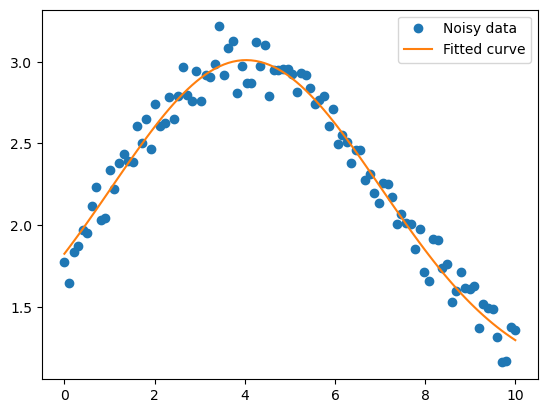

In [11]:
### Testing Gauss1D fit
import matplotlib.pyplot as plt

def generate_gaussian_data(a, b, c, d, x, noise_std=0.1):
    noise = np.random.normal(0, noise_std, len(x))
    y = a + b * np.exp(-(x - d)**2 / (2 * c**2)) + noise
    return y

def test_gauss1dfit():
    # Generate synthetic data
    a, b, c, d = 1, 2, 3, 4
    x = np.linspace(0, 10, 100)
    y = generate_gaussian_data(a, b, c, d, x)

    # Fit the data
    popt, _ = gauss1dfit(y, x)

    # Check if the fitted parameters are close to the true parameters
    np.testing.assert_allclose(popt, [a, b, c, d], rtol=0.2)

    # Plot the results for visual inspection
    plt.plot(x, y, 'o', label='Noisy data')
    plt.plot(x, gauss1dfunct(popt, x)[0], '-', label='Fitted curve')
    plt.legend()
    plt.show()

test_gauss1dfit()

In [12]:
import numpy as np

def gauss2dfunct(p, grid, return_jac=False):
    nx = grid[0]
    ny = grid[1]

    m = len(p)
    jac = np.zeros((ny * nx, m))

    tilt = len(p) == 7
    if tilt:
        xpt = np.tile(grid[2:nx+2] - p[4], (ny, 1))
        ypt = np.tile(grid[nx+2:] - p[5], (1, nx))
        s = np.sin(p[6])
        c = np.cos(p[6])
        xp = np.reshape(xpt * (c / p[2]) - ypt * (s / p[2]), ny * nx)
        yp = np.reshape(xpt * (s / p[3]) + ypt * (c / p[3]), ny * nx)
        expU = np.exp(-0.5 * (xp * xp + yp * yp))
        z = p[0] + p[1] * expU

        if return_jac:
            pexpU = p[1] * expU
            Ux = pexpU * xp / p[2]
            Uy = pexpU * yp / p[3]
            jac[:, 0] = 1
            jac[:, 1] = expU
            jac[:, 2] = Ux / p[2]
            jac[:, 3] = Uy / p[3]
            jac[:, 4] = Ux * c + Uy * s
            jac[:, 5] = -Ux * s + Uy * c
            jac[:, 6] = -pexpU * xp * yp * (p[2] / p[3] - p[3] / p[2])
            return z, jac
    else:
        xp = np.reshape(np.tile((grid[2:nx+2] - p[4]) / p[2], (ny, 1)), ny * nx)
        yp = np.reshape(np.tile((grid[nx+2:] - p[5]) / p[3], (1, nx)), ny * nx)
        expU = np.exp(-0.5 * (xp * xp + yp * yp))
        z = p[0] + p[1] * expU

        if return_jac:
            pexpU = p[1] * expU
            Ux = pexpU * xp / p[2]
            Uy = pexpU * yp / p[3]
            jac[:, 0] = 1
            jac[:, 1] = expU
            jac[:, 2] = Ux / p[2]
            jac[:, 3] = Uy / p[3]
            jac[:, 4] = Ux
            jac[:, 5] = Uy
            return z, jac

    return z

In [44]:
import numpy as np
from scipy.optimize import least_squares

def gauss2dfit(zdata, grid, tilt):
    nx, ny = grid[0], grid[1]
    z = zdata.flatten()

    # Compute moments for initial estimates
    x = np.arange(1, nx + 1)
    y = np.arange(1, ny + 1)
    X, Y = np.meshgrid(x, y)

    z_offset = np.min(zdata)
    amplitude = np.max(zdata) - z_offset

    x_center = np.sum(X * zdata) / np.sum(zdata)
    y_center = np.sum(Y * zdata) / np.sum(zdata)

    x_std = np.sqrt(np.abs(np.sum(((X - x_center) ** 2) * zdata) / np.sum(zdata)))
    y_std = np.sqrt(np.abs(np.sum(((Y - y_center) ** 2) * zdata) / np.sum(zdata)))

    p0 = [z_offset, amplitude, x_std, y_std, x_center, y_center]

    if tilt == 1:
        p0.append(0)

    def residuals(p, grid, z):
        z_model = gauss2dfunct(p, grid)
        return z - z_model

    result = least_squares(residuals, p0, args=(grid, z), method='lm', ftol=1e-10, xtol=1e-10, max_nfev=1000)

    popt = result.x
    resnorm = result.cost
    residual = result.fun
    ret = result.nfev

    return popt, resnorm, residual, ret

In [49]:
## Testing gauss2dfit
import numpy as np

def generate_2d_gaussian_data(nx, ny, z_offset, amplitude, x_std, y_std, x_center, y_center, tilt=0, noise_level=0.1):
    x = np.linspace(1, nx, nx)
    y = np.linspace(1, ny, ny)
    xv, yv = np.meshgrid(x, y)

    s = np.sin(tilt)
    c = np.cos(tilt)

    xp = (xv - x_center) * c / x_std + (yv - y_center) * s / x_std
    yp = -(xv - x_center) * s / y_std + (yv - y_center) * c / y_std

    z = z_offset + amplitude * np.exp(-0.5 * (xp ** 2 + yp ** 2))

    noise = np.random.normal(0, noise_level * amplitude, (ny, nx))
    z_noisy = z + noise

    return z_noisy

def test_gauss2dfit():
    np.random.seed(42)
    
    nx, ny = 100, 100
    z_offset, amplitude = 4.0, 100.0
    x_std, y_std = 10.0, 15.0
    x_center, y_center = 45, 55
    tilt = 0

    # Test with different noise levels
    noise_levels = [0, 0.1 * amplitude, 0.2 * amplitude]
    tolerance = 0.5

    for noise_level in noise_levels:
        synthetic_data = generate_2d_gaussian_data(nx, ny, z_offset, amplitude, x_std, y_std, x_center, y_center, tilt, noise_level)
        grid = np.hstack(([nx, ny], np.arange(1, nx + 1), np.arange(1, ny + 1)))
        popt, _, _, _ = gauss2dfit(synthetic_data, grid, tilt)

        true_params = np.array([z_offset, amplitude, x_std, y_std, x_center, y_center])
        relative_errors = np.abs((popt - true_params) / true_params)

        assert np.all(relative_errors < tolerance), f"Noise level: {noise_level}, Relative errors exceed tolerance: {relative_errors}"

test_gauss2dfit()

AssertionError: Noise level: 10.0, Relative errors exceed tolerance: [ 4075.18433053  1001.92202447 53213.08639793  9136.6267564
 15919.01101386  3360.08282557]

In [58]:
def PSFfit(IMAGE, pxl_size):
    ny, nx = IMAGE.shape
    grid = [nx, ny] + list(range(1, nx+1)) + list(range(1, ny+1))
    popt, _, _, _ = gauss2dfit(np.abs(IMAGE), grid, 0)

    if popt.size != 0:
        xp = np.reshape(np.repeat((grid[2:nx+2] - popt[4]) / popt[2], ny), (ny * nx, 1)).flatten()
        yp = np.reshape(np.repeat((grid[nx+2:] - popt[5]) / popt[3], nx), (ny * nx, 1)).flatten()

        expU = np.exp(-0.5 * (xp * xp + yp * yp))
        z = popt[0] + popt[1] * expU

        N = np.sum(z - popt[0])
        z = np.reshape(z, (ny, nx))
        si_x = popt[2] * pxl_size
        si_y = popt[3] * pxl_size
        a = pxl_size

        bkg = np.reshape(IMAGE - z, 1, []).flatten()
        b = np.std(bkg)

        sig_ax2 = si_x ** 2 + a ** 2 / 12
        sig_ay2 = si_y ** 2 + a ** 2 / 12

        eps = 1e-10
        sig_x = np.sqrt(sig_ax2 / (N + eps) * (16 / 9 + 8 * np.pi * sig_ax2 * b ** 2 / ((N + eps) * a ** 2)))
        sig_y = np.sqrt(sig_ay2 / (N + eps) * (16 / 9 + 8 * np.pi * sig_ay2 * b ** 2 / ((N + eps) * a ** 2)))
    else:
        sig_x, sig_y, N = [], [], []

    return sig_x, sig_y, N